In [58]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000-006.root"

In [59]:
from mu2etools import wideband
from mu2etools import *

processor = wideband.DataProcessor(usexroot=True, fixtimes=True)
ar, arSpills = processor.getData(DATASET)
df = ak.to_dataframe(ar) # entry - event, subentry - FEB, subsubentry - AFE
dfSpills = ak.to_dataframe(arSpills) # 

In [60]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000-006.root
Number of FEBs: 6
List of FEBs: [22, 25, 17, 14, 20, 1]


In [61]:
wideband.MAX_TEMP = 25

Temperature at CMB vs time

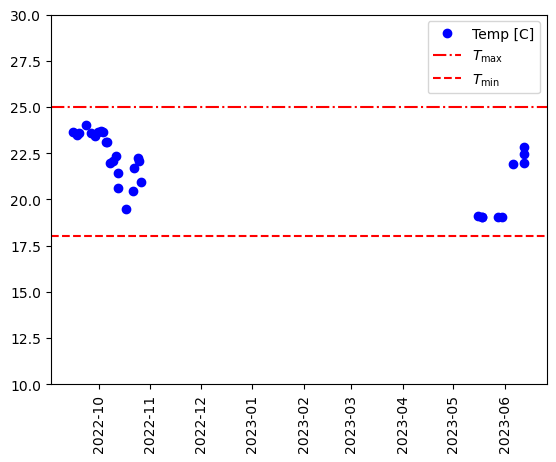

In [62]:
cut = (ar['timestamp'] > 0)
x=ar["timestamp", cut].to_numpy()
y=ar["meanTemperatures", cut][:,0,0].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, 'bo', label='Temp [C]')
plt.xticks(rotation=90);
plt.ylim(10, 30)
plt.axhline(y=wideband.MAX_TEMP, color='r', linestyle='-.', label=r'$T_{\max}$')
plt.axhline(y=wideband.MIN_TEMP, color='r', linestyle='--', label=r'$T_{\min}$');
plt.legend();

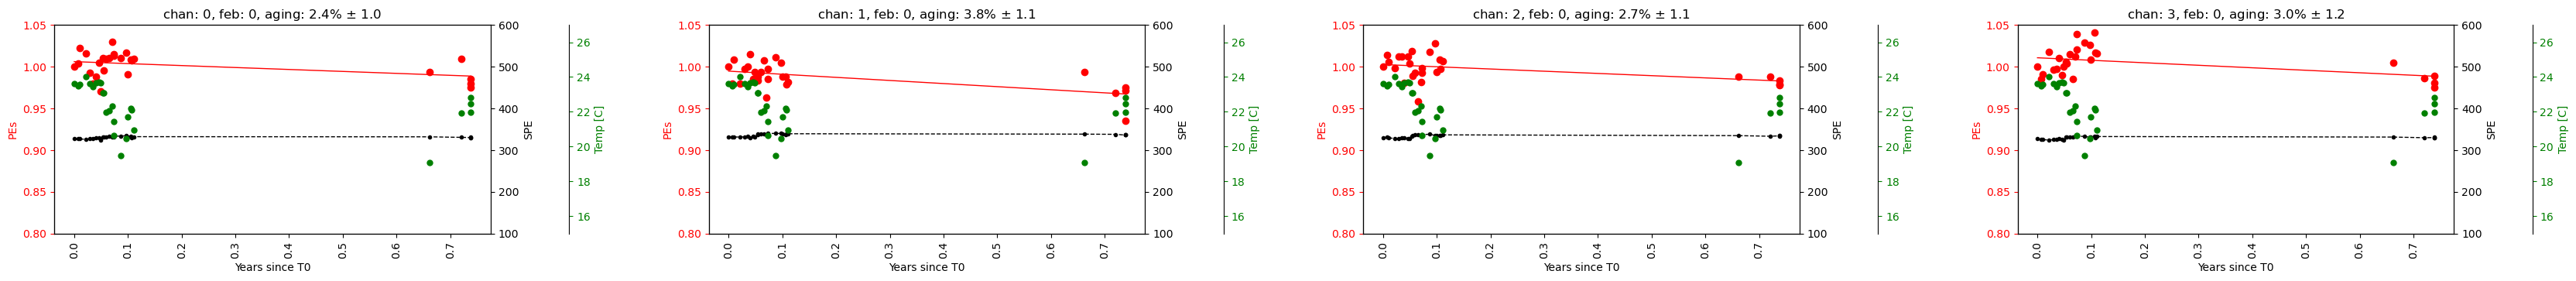

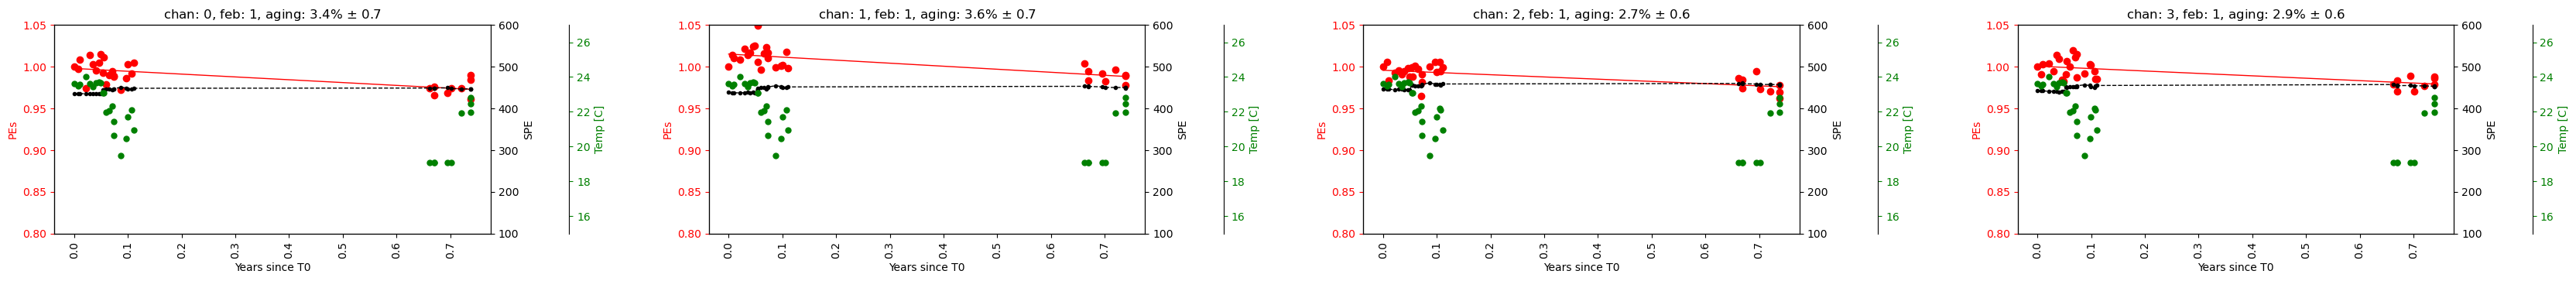

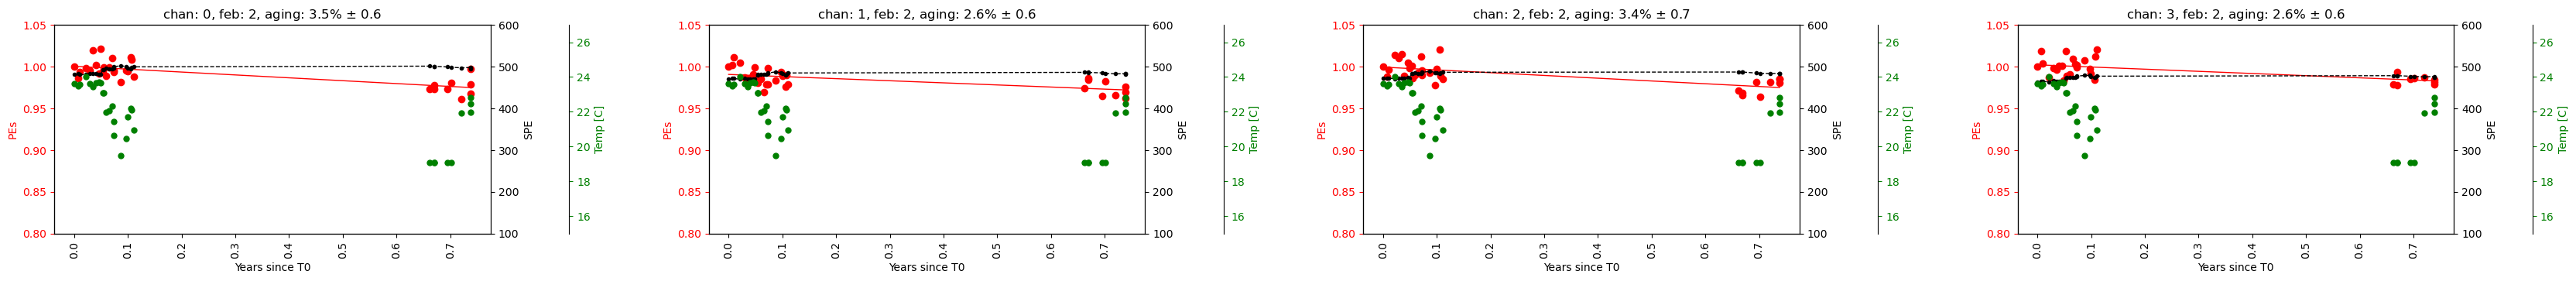

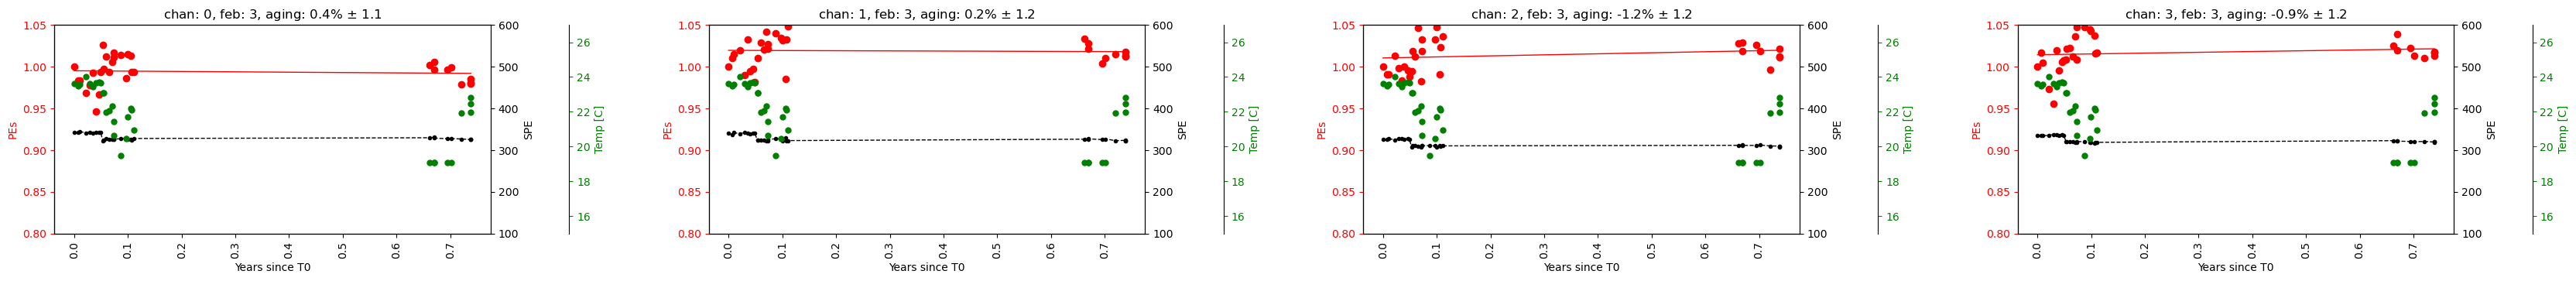

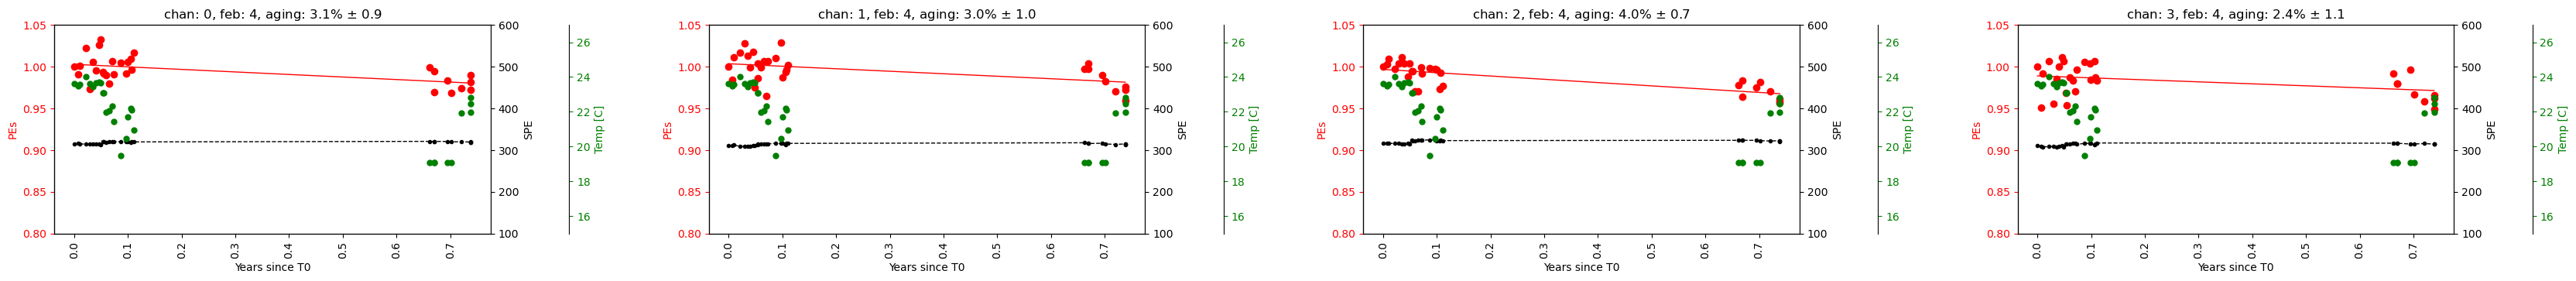

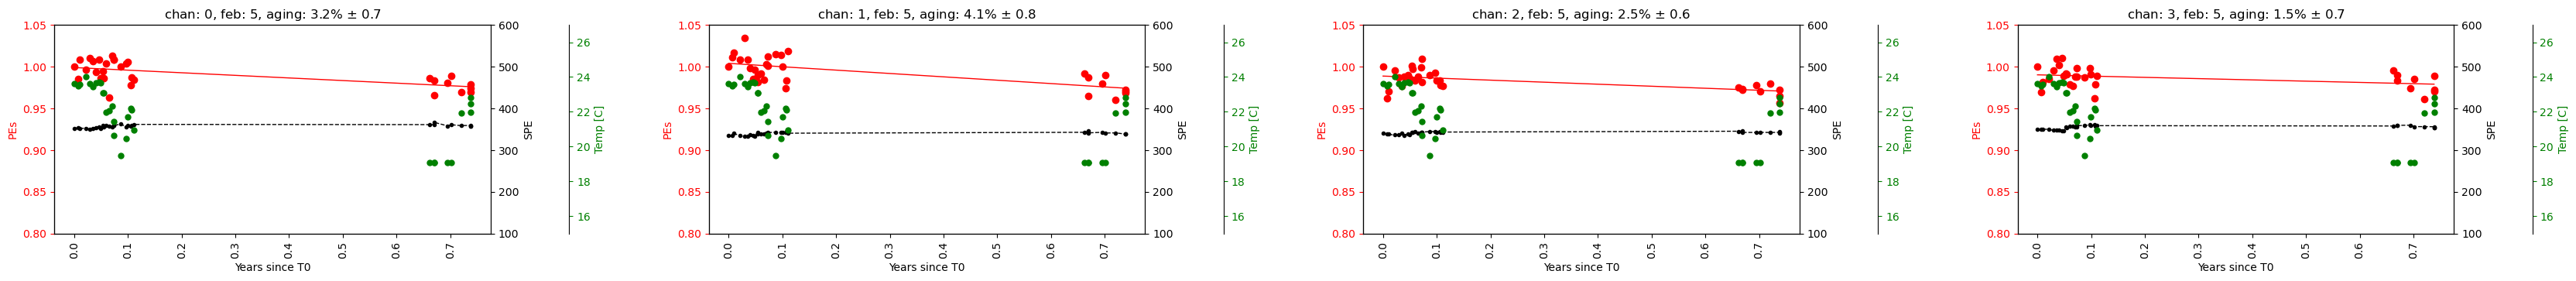

In [63]:
# Define the exponential function to fit
def func(x, a, b):
    return a * np.exp(-b*x/100) # return aging rate in %
#    return a -b*x/100 # return aging rate in %

df_age = pd.DataFrame(columns=['age_rate', 'age_rate_std', 'res_std', 'chi2', 'chan', 'feb'])

#Filter only data within a narrow temperature range
cut=(ar['meanTemperatures'][:, 0, 0]>wideband.MIN_TEMP) & (ar['meanTemperatures'][:, 0, 0]<wideband.MAX_TEMP)
#ar_=ar[cut]
ar_=ar

for feb in range(0, NFEBS):
    
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))

    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation=90)    
    
    for chan_infeb in range(wideband.NCHAN_FEB):

        chan = chan_infeb%wideband.NCHAN_CMB
        cut = (ar_['PEsTemperatureCorrected'][:, feb, chan_infeb] > 0) & (ar_['stddevTemperatures'][:, feb, chan_infeb] > 0.001)
        y = ar_['PEsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
        if len(y) == 0:
            continue

        y = y / y[0]
        t0 = ar_['timestamp', cut][0]
        x = (ar_['timestamp', cut] - t0)/wideband.SEC_YEAR
        x = x.to_numpy()        
        popt, pcov = curve_fit(func, x, y, p0=[1, 5])
        
        a, age_rate = popt
        y_fit = func(x, a, age_rate)

        age_rate_std = np.sqrt(np.diag(pcov))[1] # Aging rate error 
        residuals = y - y_fit
        res_std = np.std(residuals)
        chisq = np.sum(residuals**2)
        dof = len(x) - len(popt)
        reduced_chi2 = chisq/dof
        
        # Plot only first 4 channels from FEBs
        if chan_infeb < 4:
            ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(chan_infeb,feb,age_rate,age_rate_std))
            ax1[chan].plot(x, y_fit, 'r-', linewidth=1, label='Fit')
            ax1[chan].set_ylim(0.8, 1.05)
            ax1[chan].set_ylabel('PEs', color='r')
            ax1[chan].set_xlabel('Years since T0')
            ax1[chan].tick_params(axis='y', which='both', colors='r')
            ax1[chan].tick_params(axis='x', rotation=90)
            ax1[chan].plot(x, y, 'ro')

            y = ar_['calibConstantsTemperatureCorrected', cut][:, feb, chan_infeb].to_numpy()
            
            ax2 = ax1[chan].twinx()
            ax2.plot(x, y, 'k.--', linewidth=1)
            ax2.set_ylim(100, 600)
            ax2.set_ylabel('SPE', color='k')

            y = ar_['meanTemperatures', cut][:, 0, 0].to_numpy()
            ax3 = ax1[chan].twinx()
            ax3.plot(x, y, 'go', markersize=5.0)
            ax3.spines['right'].set_position(("axes", 1.18))
            ax3.set_ylabel('Temp [C]', color='g')
            ax3.set_ylim(15, 27)
            ax3.tick_params(axis='y', which='both', colors='g')

        #fill dataframe
        new_row = {'age_rate': age_rate, 'age_rate_std':age_rate_std, 'res_std':res_std, 'chi2':reduced_chi2, 'chan':chan_infeb, 'feb':feb}
        df_age.loc[len(df_age)] = new_row
        
df_age['chi2_norm'] = df_age['chi2']/(df_age['res_std']**2).mean()

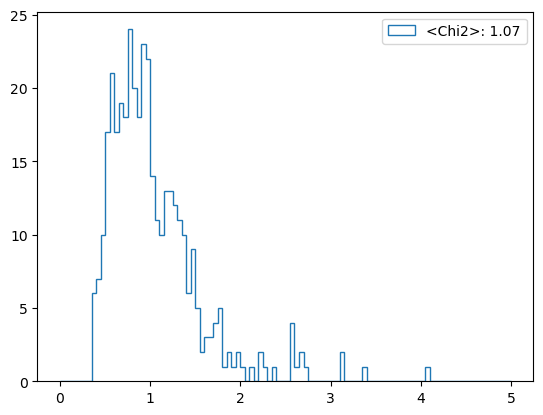

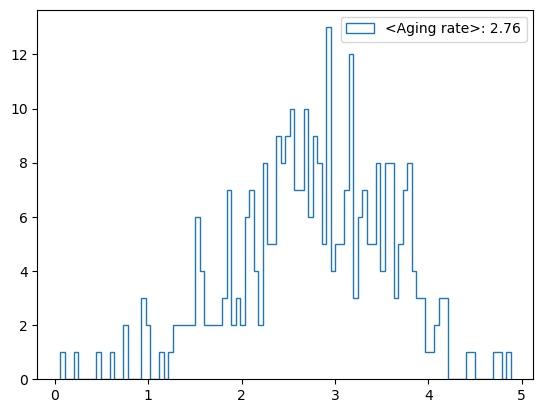

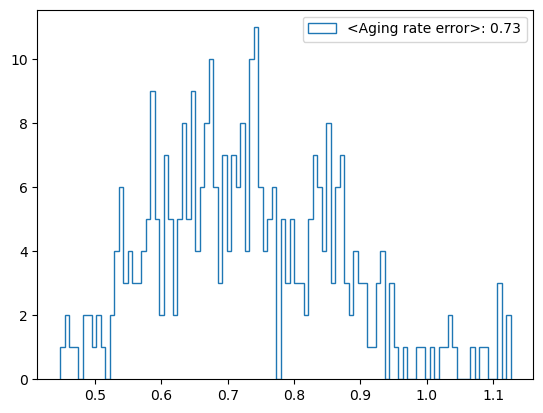

In [64]:
x=df_age['chi2_norm']
plt.hist(x, histtype='step', bins=100, range=(0,5), label="<Chi2>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('chi2_norm<1.5')['age_rate']
plt.hist(x, histtype='step', bins=100, label="<Aging rate>: %.2f"%x.mean());
plt.legend()

plt.figure()
x=df_age.query('chi2_norm<1.5')['age_rate_std']
plt.hist(x, histtype='step', bins=100, label="<Aging rate error>: %.2f"%x.mean());
plt.legend();

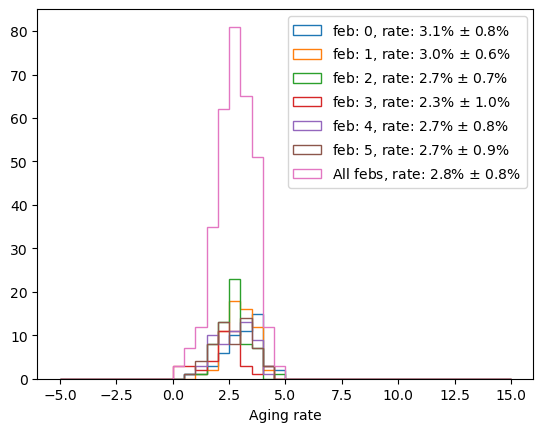

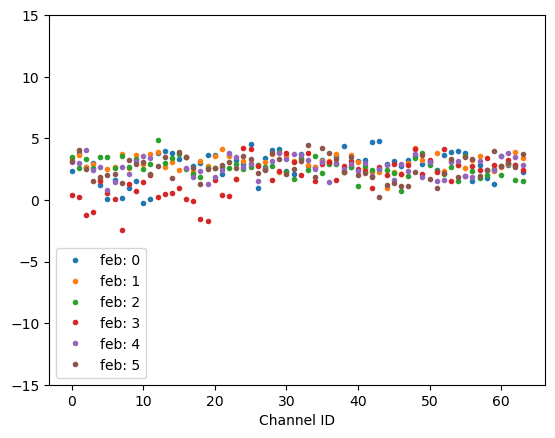

In [65]:
for feb in range(0,NFEBS):
    x=df_age.query('chi2_norm<1.5 & feb==%d'%feb)['age_rate']
    plt.hist(x, histtype='step', range=(-5,15), bins=40, label='feb: %d, rate: %0.1f%% $\pm$ %.1f%%'%(feb,x.mean(),x.std()));
plt.xlabel('Aging rate')

x=df_age.query('chi2_norm<1.5')['age_rate']
plt.hist(x, histtype='step', range=(-5,15), bins=40, label='All febs, rate: %0.1f%% $\pm$ %.1f%%'%(x.mean(),x.std()));
plt.legend();


plt.figure()
for feb in range(0,NFEBS):
    x=df_age.query('feb==%d'%feb)['chan']
    y=df_age.query('feb==%d'%feb)['age_rate']
    plt.plot(x, y, '.', label='feb: %d'%feb);
plt.legend();
plt.xlabel('Channel ID')
plt.ylim(-15,15);

In [66]:
import datetime
current_time = datetime.datetime.now()
print(DATASET)
print("Current time:", current_time)

rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000-006.root
Current time: 2023-08-07 00:59:17.800791


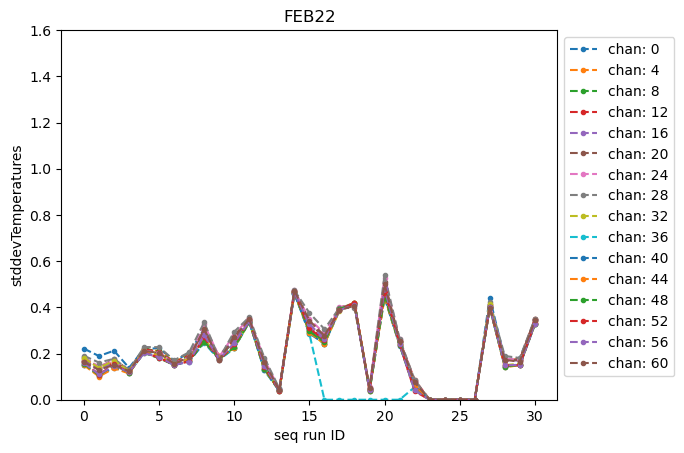

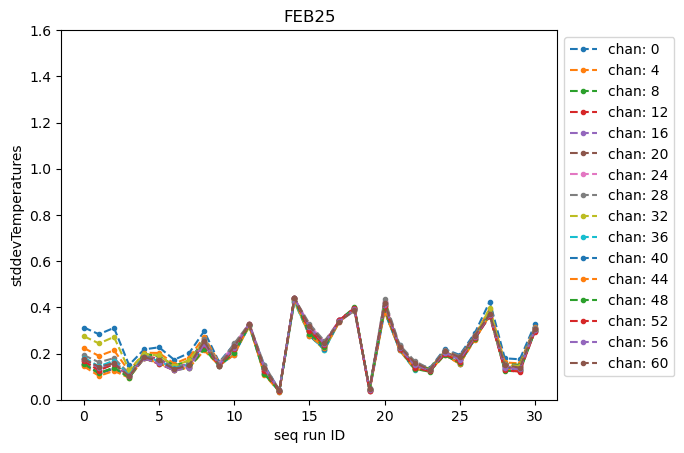

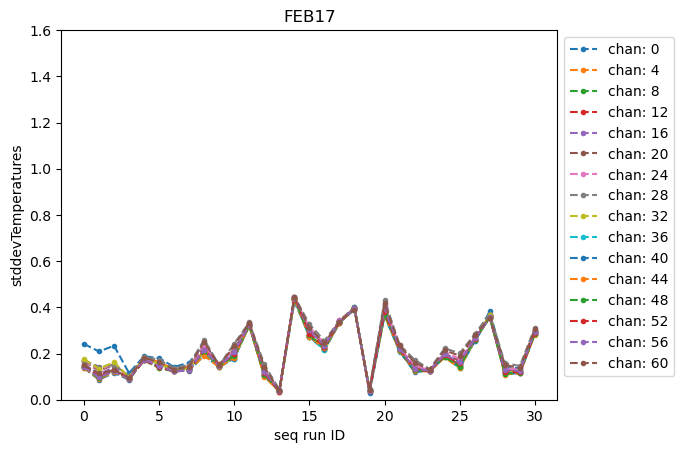

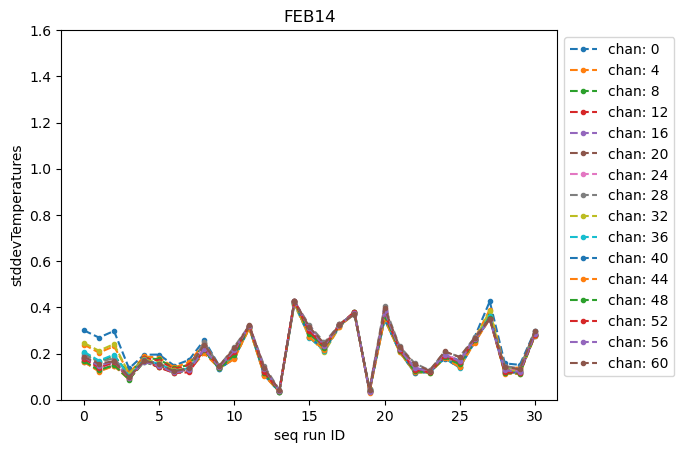

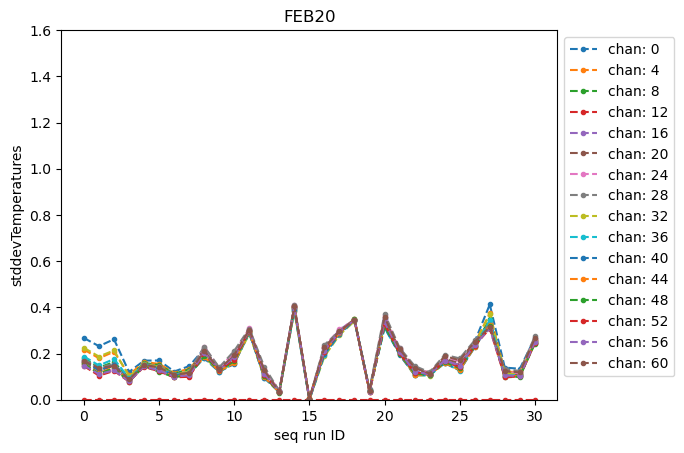

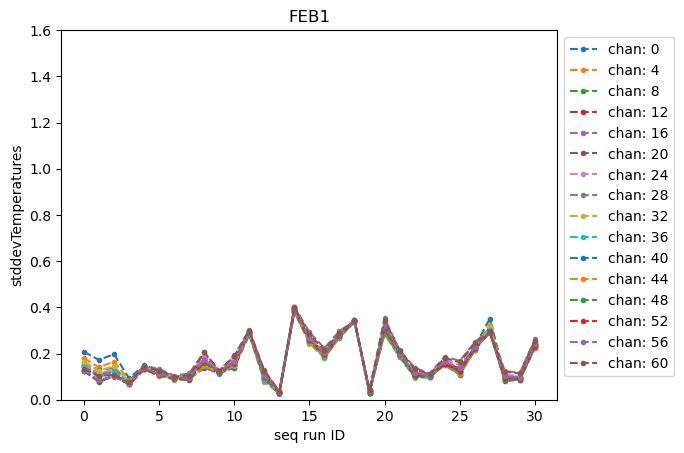

In [67]:
for feb, fid in enumerate(FEBID):
    plt.figure()
    for chan in range(0, 64, 4):
        plt.plot(ar['stddevTemperatures'][:,feb,chan], "--.", label="chan: %d"%chan);
    plt.ylabel('stddevTemperatures')
    plt.xlabel('seq run ID')
    plt.title('FEB%d'%fid)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.ylim(0, 1.6)